In [2]:
#INSTALLING DEPENDENCIES
# This script installs the necessary Python packages for data analysis and machine learning.
!pip install pandas scikit-learn cassandra-driver matplotlib seaborn



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\HARSHITA\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
#IMPORT LIBRARIES
import pandas as pd
from cassandra.cluster import Cluster
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [4]:
# Connect to Cassandra
cluster = Cluster(['localhost'])
session = cluster.connect()
session.execute("USE ecommerce")

# Query data
query = """
SELECT customer_id, product_category, sales, quantity, discount, profit, shipping_cost
FROM orders;
"""
rows = session.execute(query)

# Load into DataFrame
data = pd.DataFrame(rows)

print("Data loaded.")
data.head()


Data loaded.


,customer_id,product_category,sales,quantity,discount,profit,shipping_cost
0,64256,Home & Furniture,67.0,3.0,0.2,22.3,2.2
1,64256,Home & Furniture,216.0,2.0,0.1,131.7,13.2
2,26941,Fashion,122.0,5.0,0.5,35.9,3.6
3,23937,Auto & Accessories,231.0,5.0,0.3,93.3,9.3
4,79290,Fashion,159.0,1.0,0.2,75.8,7.6


In [5]:
#CLEANING DATA# Check for missing values

# Convert numeric columns
for col in ['sales', 'quantity', 'discount', 'profit', 'shipping_cost']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop rows with missing values
data = data.dropna()

# 'product_category' is already encoded as dummy variables in the DataFrame.
# No need to encode again.
# data = pd.get_dummies(data, columns=['product_category'], drop_first=True)

print(" Data cleaned.")
data.head()


 Data cleaned.


,customer_id,product_category,sales,quantity,discount,profit,shipping_cost
0,64256,Home & Furniture,67.0,3.0,0.2,22.3,2.2
1,64256,Home & Furniture,216.0,2.0,0.1,131.7,13.2
2,26941,Fashion,122.0,5.0,0.5,35.9,3.6
3,23937,Auto & Accessories,231.0,5.0,0.3,93.3,9.3
4,79290,Fashion,159.0,1.0,0.2,75.8,7.6


In [6]:
# Show basic statistics
data.describe()


,sales,quantity,discount,profit,shipping_cost
count,51285.000000,51285.000000,51285.000000,51285.000000,51285.000000
mean,152.340548,2.502935,0.303833,70.404395,7.041427
std,66.492851,1.511834,0.131024,48.728944,4.871768
min,33.000000,1.000000,0.100000,0.500000,0.100000
25%,85.000000,1.000000,0.200000,24.900000,2.500000
50%,133.000000,2.000000,0.300000,59.900000,6.000000
75%,218.000000,4.000000,0.400000,118.400000,11.800000
max,250.000000,5.000000,0.500000,167.500000,16.800000


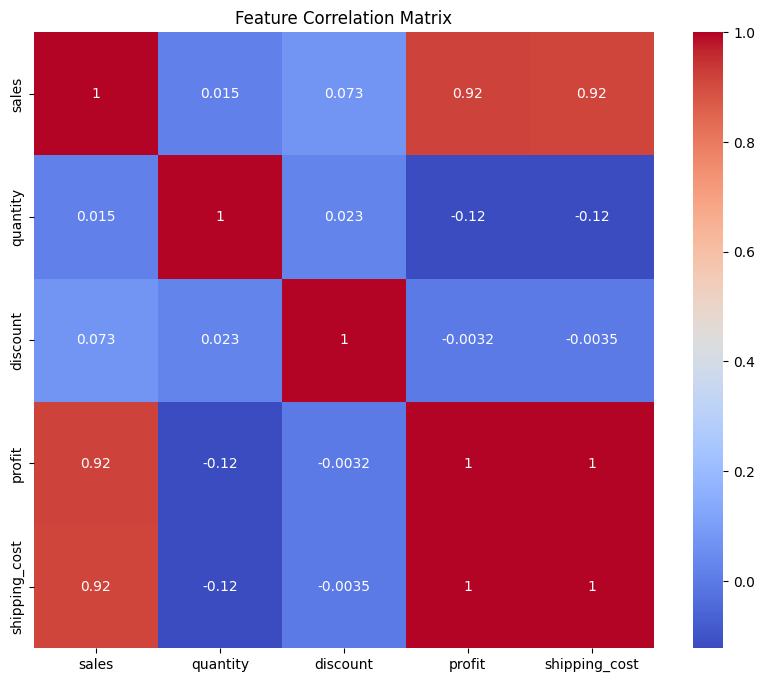

In [8]:
#CORELATION MATRIX
# Visualize correlation matrix for numeric columns only
numeric_data = data.select_dtypes(include=[np.number])
plt.figure(figsize=(10,8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [9]:
#PREPARING DATA FOR MODELING
# Split data into features and target variable
X = data.drop(['sales', 'customer_id'], axis=1)
y = data['sales']

X.head()
y.head()

0     67.0
1    216.0
2    122.0
3    231.0
4    159.0
Name: sales, dtype: float64

In [10]:
#TRAIN/TEST SPLIT
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(" Train/test split complete.")


 Train/test split complete.


In [16]:
# Remove 'product_category' column before converting to numeric
X_train_num = X_train.drop(columns=['product_category'])
X_test_num = X_test.drop(columns=['product_category'])

# Convert numeric columns
X_train_num = X_train_num.apply(pd.to_numeric, errors='coerce')
X_test_num = X_test_num.apply(pd.to_numeric, errors='coerce')
y_train_num = pd.to_numeric(y_train, errors='coerce')
y_test_num = pd.to_numeric(y_test, errors='coerce')

# Drop any rows with NaNs in training set
train_mask = ~X_train_num.isnull().any(axis=1)
X_train_clean = X_train_num[train_mask]
y_train_clean = y_train_num[train_mask]

# Confirm shapes
print("X_train shape:", X_train_clean.shape)
print("y_train shape:", y_train_clean.shape)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_clean, y_train_clean)

print("Random Forest model trained.")
y_pred = rf_model.predict(X_test_num)


X_train shape: (41028, 4)
y_train shape: (41028,)
Random Forest model trained.


In [18]:
# Evaluate the model AND print metrics
y_pred_rf = rf_model.predict(X_test_num)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"🎯 Random Forest R² Score: {r2_rf:.4f}")
print(f"🎯 Random Forest RMSE: {rmse_rf:.4f}")


🎯 Random Forest R² Score: 0.9981
🎯 Random Forest RMSE: 2.8706


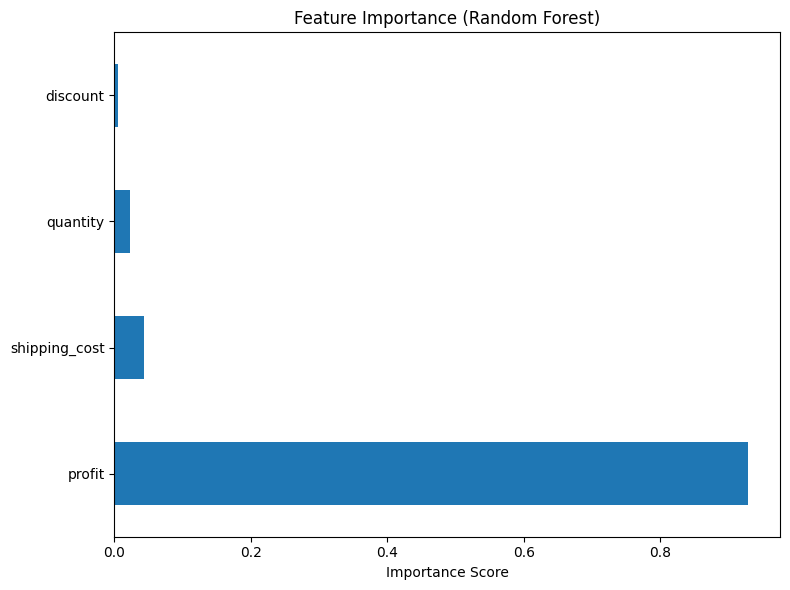

In [20]:
#FEATURE IMPORTANCE
importances = pd.Series(
    rf_model.feature_importances_,
    index=X_train_clean.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.plot(kind='barh')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


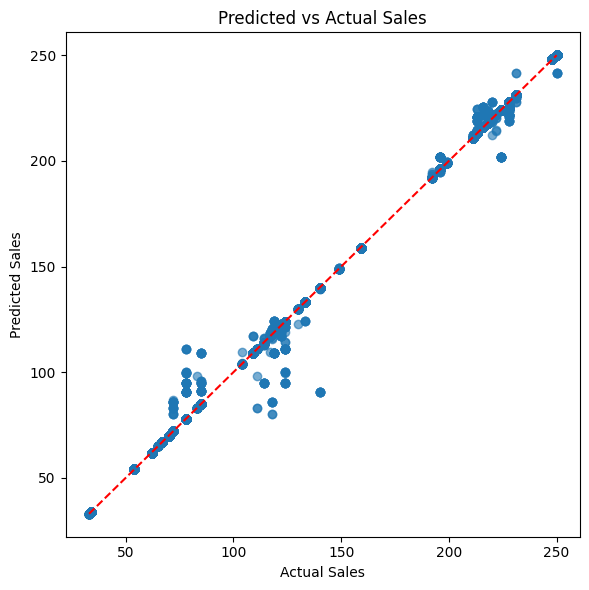

In [21]:
#PREDICTED VS ACTUAL SALES
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales")
plt.tight_layout()
plt.show()


In [ ]:
data.to_csv("processed_ecommerce_data.csv", index=False)
